In [68]:
import numpy
import torch
from torchvision import datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import random_split, DataLoader

Load CIFAR-10 dataset and split

In [69]:
transform = v2.Compose([
    v2.ToTensor()
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# This custom split is from the official training data and does not use the official testing data
generator = torch.Generator().manual_seed(7)
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

Min-Max Scaling to [-1,1]

In [70]:
def compute_min_max(dataset):
    min_unscaled = float("inf")
    max_unscaled = float("-inf")
    for i in range(len(dataset)):
        x, _ = dataset[i]
        min_unscaled = min(min_unscaled, x.min().item())
        max_unscaled = max(max_unscaled, x.max().item())
    return min_unscaled, max_unscaled

class MinMaxScaling:
    def __init__(self, min_unscaled, max_unscaled, min_scaled, max_scaled):
        self.min_unscaled = min_unscaled
        self.max_unscaled = max_unscaled
        self.min_scaled = min_scaled
        self.max_scaled = max_scaled
    
    def __call__(self, x):
        return ((x-self.min_unscaled)/(self.max_unscaled-self.min_unscaled))*(self.max_scaled-self.min_scaled)+self.min_scaled

Z-score Normalization

In [71]:
def compute_mean_std(dataset):
    x0, _ = dataset[0] # get first image from dataset to extract dimensions
    c = x0.shape[0]

    sum_n = torch.zeros(c)
    sum_sq = torch.zeros(c)
    num_pixels = 0

    for i in range(len(dataset)):
        x, _ = dataset[i]
        sum_n += x.sum(dim=(1,2))
        sum_sq += (x ** 2).sum(dim=(1,2))
        num_pixels += x.shape[1] * x.shape[2]
    
    mean = sum_n / num_pixels
    std = torch.sqrt(sum_sq / num_pixels - mean ** 2)

    return mean, std

Apply the data transformations

In [72]:
data_mean, data_std = compute_mean_std(train_set)
data_min, data_max = compute_min_max(train_set)

train_set.transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=data_mean, std=data_std),
    MinMaxScaling(data_min, data_max, 0, 1),

    v2.RandomHorizontalFlip(p=0.5), # add ability to control these parameters later
    v2.RandomCrop((16,16)),
    v2.GaussianNoise(mean=0, sigma=0.1),
    v2.ColorJitter()
])

Preview the data

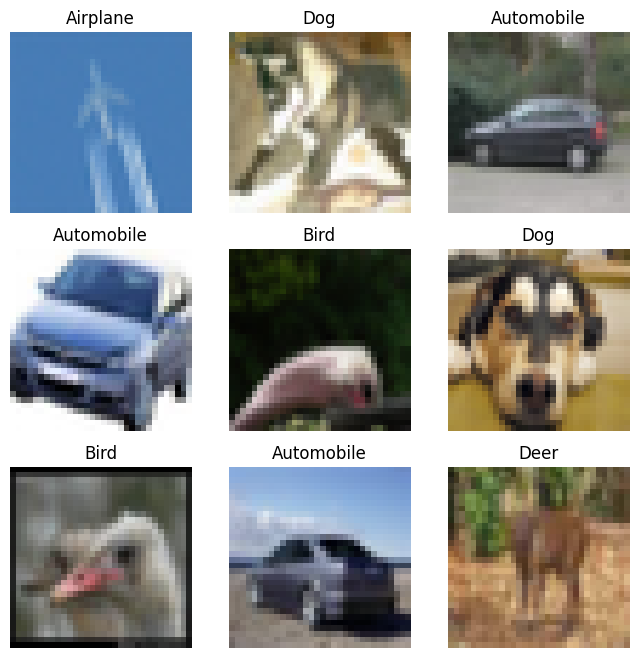

In [78]:
import matplotlib.pyplot as plt

labels = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()